##  <span style='color:green '>Evaluate Models</scan>
##  <span style='color:green '>Fantasy Football Sleeper Draft Selection </scan>
###  <span style='color:green '>This notebook evaluates the best model for Quarterback only predictions.  
Not all options evaluated remain in this anaysis. Some of the options evaluated are presently commented out for ease of future evaluations - as available features are continuing to be optimized to achieve the most acurate results. You may find a companion notebook for neural network evaluations for the same dataset. </scan>

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')
import nfl_data_py as nfl
pd.get_option("display.max_columns")

###  <span style='color:green '> Set up variables to be used in Fit Determination Function</scan>

In [40]:
index = []
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
scalers = ["none", StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]
models = [LinearRegression(),
          LogisticRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(),
          RandomForestClassifier(),
          ExtraTreesRegressor(),
          ExtraTreesClassifier(),
          AdaBoostRegressor(),
          AdaBoostClassifier()]

# Variables for year substitution 
C2021 = ['2021 Games', '2021 FantasyPoints','2021 GS','2021 Tgt', '2021 Rec', '2021 RushingTD',
        '2021 RushingYds', '2021 RushingAtt', '2021 ReceivingYds', '2021 ReceivingTD']
C2020 = ['2020 Games', '2020 FantasyPoints','2020 GS','2020 Tgt', '2020 Rec', '2020 RushingTD',
        '2020 RushingYds', '2020 RushingAtt', '2020 ReceivingYds', '2020 ReceivingTD']
C2019 = ['2019 Games', '2019 FantasyPoints','2019 GS','2020 Tgt', '2019 Rec', '2019 RushingTD',
        '2019 RushingYds', '2019 RushingAtt', '2019 ReceivingYds', '2019 ReceivingTD']

###  <span style='color:green '>Define Function to Test Models and Scalers</scan>

In [41]:
def test_model(data):
    for scaler in scalers:
        global index
        global scores
        if scaler != "none":
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        data = X_train_scaled, X_test_scaled, y_train, y_test
        for model in models:
            reg = model.fit(X_train_scaled, y_train)
            y_pred = reg.predict(X_test_scaled)            
            scores["Train Score"].append(reg.score(X_train_scaled, y_train))
            scores["Test Score"].append(reg.score(X_test_scaled, y_test))
            scores["Test Train Difference"].append((reg.score(X_train_scaled, y_train)-(reg.score(X_test_scaled, y_test))))
            scores["Scaler"].append(scaler)
            index += [type(reg).__name__]

###  <span style='color:green '>Get data and evaluate readiness for model</scan>

 <span style='color:green '>* Find features and target   
     * Test for imbalance </scan>

In [42]:
nfl.see_pbp_cols()
pbp2021 = nfl.import_pbp_data(years=[2021], downcast=True, cache=False, alt_path=None)
pbp2021


# load additional team data 
pbpclean = pbp2021
teams = nfl.import_team_desc()
players = nfl.import_rosters([2021])
player_seasons = nfl.import_seasonal_data([2021])
player_seasons.head(5)

adp = pd.read_csv('Resources/QBxADPxFinal.csv') 

# When ineligible players are dropped before training the model scores suffer
# Nulls are preserved and dropped just before the Predicted file is created
# Drop players ineligible to be drafted 
# adp = adp.dropna(subset=['AVG'])

# Preserve label information for Output file 
adp_scope = adp[['Player',
                 '2019 FantasyPoints',
                 '2020 FantasyPoints',
                 '2021 FantasyPoints',
                 'Production21',
                 'Average Total Production',
                 '2021 Tm',
                 'Pos',
                 'AVG'
                ]].copy()

2021 done.
Downcasting floats.


In [43]:
# Correct "inf" and "-inf" values 
# Replace infinite updated data with 'drop'
# drop these rows from what will become our result set 
adp_scope.replace([np.inf, -np.inf], 'drop', inplace=True)
res = adp_scope[~adp_scope.eq('drop').any(1)]
adp_scope  = res
adp_scope

,Player,2019 FantasyPoints,2020 FantasyPoints,2021 FantasyPoints,Production21,Average Total Production,2021 Tm,Pos,AVG
0,Josh Allen,282.56,395.0,403.0,261.352941,247.325980,BUF,QB,22.8
1,Justin Herbert,0.00,333.0,381.0,297.176471,196.103268,LAC,QB,37.8
2,Lamar Jackson,415.68,333.0,240.0,241.500000,212.633333,BAL,QB,49.3
3,Joe Burrow,0.00,174.0,314.0,290.312500,186.804167,CIN,QB,56.5
4,Kyler Murray,279.28,379.0,300.0,272.214286,251.967262,ARI,QB,59.3
...,...,...,...,...,...,...,...,...,...
78,Jacob Eason,0.00,0.0,-1.0,25.000000,8.333333,IND,QB,0.0
79,Feleipe Franks,0.00,0.0,-1.0,0.000000,0.000000,ATL,QB,0.0
80,Logan Woodside,0.00,1.0,-1.0,0.000000,0.388889,TEN,QB,0.0
81,John Wolford,0.00,13.0,-2.0,1.666667,77.555556,LAR,QB,0.0


In [44]:
adp

,Unnamed: 0,Player,Pos,2021 Tm,2021 PassingYds,2021 PassingTD,2021 PassingAtt,2021 RushingYds,2021 RushingTD,2021 FantasyPoints,2021 Games,2020 PassingYds,2020 PassingTD,2020 PassingAtt,2020 RushingYds,2020 RushingTD,2020 FantasyPoints,2020 Games,2019 PassingYds,2019 PassingTD,2019 PassingAtt,2019 RushingYds,2019 RushingTD,2019 FantasyPoints,2019 Games,Production19,Touchdowns19,TotYdsScrm19,Production20,Touchdowns20,TotYdsScrm20,Production21,Touchdowns21,TotYdsScrm21,Average Total Yards,Average Total Production,AVG
0,0,Josh Allen,QB,BUF,4407.0,36.0,646.0,763.0,6.0,403.0,17,4544.0,37.0,572.0,421.0,8.0,395.0,16.0,3089.0,20.0,461.0,510.0,9.0,282.56,16.0,194.312500,29.0,3599.0,286.312500,45.0,4965.0,261.352941,42.0,5170.0,4578.000000,247.325980,22.8
1,1,Justin Herbert,QB,LAC,5014.0,38.0,672.0,302.0,3.0,381.0,17,4336.0,31.0,595.0,234.0,5.0,333.0,15.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,291.133333,36.0,4570.0,297.176471,41.0,5316.0,3295.333333,196.103268,37.8
2,15,Lamar Jackson,QB,BAL,2882.0,16.0,382.0,767.0,2.0,240.0,12,2757.0,26.0,376.0,1005.0,7.0,333.0,15.0,3127.0,36.0,401.0,1206.0,7.0,415.68,15.0,210.866667,43.0,4333.0,185.533333,33.0,3762.0,241.500000,18.0,3649.0,3914.666667,212.633333,49.3
3,7,Joe Burrow,QB,CIN,4611.0,34.0,520.0,118.0,2.0,314.0,16,2688.0,13.0,404.0,142.0,3.0,174.0,10.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,270.100000,16.0,2830.0,290.312500,36.0,4729.0,2519.666667,186.804167,56.5
4,9,Kyler Murray,QB,ARI,3787.0,24.0,481.0,423.0,5.0,300.0,14,3971.0,26.0,558.0,819.0,11.0,379.0,16.0,3722.0,20.0,542.0,544.0,4.0,279.28,16.0,233.875000,24.0,4266.0,249.812500,37.0,4790.0,272.214286,29.0,4210.0,4422.000000,251.967262,59.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,78,Jacob Eason,QB,IND,25.0,0.0,5.0,0.0,0.0,-1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.000000,0.0,25.0,8.333333,8.333333,0.0
79,79,Feleipe Franks,QB,ATL,0.0,0.0,1.0,6.0,0.0,-1.0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,6.0,2.000000,0.000000,0.0
80,80,Logan Woodside,QB,TEN,0.0,0.0,0.0,-6.0,0.0,-1.0,5,7.0,0.0,3.0,10.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,1.166667,0.0,17.0,0.000000,0.0,-6.0,3.666667,0.388889,0.0
81,81,John Wolford,QB,LAR,5.0,0.0,4.0,-1.0,0.0,-2.0,3,231.0,0.0,38.0,56.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,231.000000,0.0,287.0,1.666667,0.0,4.0,97.000000,77.555556,0.0


In [45]:
# # Variables for year substitution 
CKS = ['Active2021', 'Active2020', 'Active2019']
C2021 = ['2021 PassingYds', '2021 PassingTD','2021 PassingAtt', '2021 RushingTD',
        '2021 RushingYds', '2021 RushingTD', '2021 Games']
C2020 = ['2020 PassingYds', '2020 PassingTD','2020 PassingAtt', '2020 RushingTD',
        '2020 RushingYds', '2020 RushingTD', '2020 Games']
C2019 = ['2019 PassingYds', '2019 PassingTD','2019 PassingAtt', '2019 RushingTD',
        '2019 RushingYds', '2019 RushingTD', '2019 Games']

# Create Checksum for years 
adp['Active2021'] = adp[C2021].sum(axis=1)
adp['Active2020'] = adp[C2020].sum(axis=1)
adp['Active2019'] = adp[C2019].sum(axis=1)

# Drop any player with no combined stats for 2021
adp.drop(adp[(adp['Active2021'] == 0)].index)

# Replace 2020 stats with 2021 stats for learning model 
adp.loc[adp["Active2020"] == 0, '2020 Games'] = adp['2021 Games']
adp.loc[adp["Active2020"] == 0, '2020 FantasyPoints'] = adp['2021 FantasyPoints']
adp.loc[adp["Active2020"] == 0, '2020 PassingYds'] = adp['2021 PassingYds']
adp.loc[adp["Active2020"] == 0, '2020 PassingTD'] = adp['2021 PassingTD']
adp.loc[adp["Active2020"] == 0, '2020 PassingAtt'] = adp['2021 PassingAtt']
adp.loc[adp["Active2020"] == 0, '2020 RushingTD'] = adp['2021 RushingTD']
adp.loc[adp["Active2020"] == 0, '2020 RushingYds'] = adp['2021 RushingYds']


# Replace 2019 stats with 2020 stats for learning model 
adp.loc[adp["Active2019"] == 0, '2019 Games'] = adp['2020 Games']
adp.loc[adp["Active2019"] == 0, '2019 FantasyPoints'] = adp['2020 FantasyPoints']
adp.loc[adp["Active2019"] == 0, '2019 PassingYds'] = adp['2020 PassingYds']
adp.loc[adp["Active2019"] == 0, '2019 PassingTD'] = adp['2020 PassingTD']
adp.loc[adp["Active2019"] == 0, '2019 PassingAtt'] = adp['2020 PassingAtt']
adp.loc[adp["Active2019"] == 0, '2019 RushingTD'] = adp['2020 RushingTD']
adp.loc[adp["Active2019"] == 0, '2019 RushingYds'] = adp['2020 RushingYds']


# Get inactive stats 
notA21 = list(adp['Active2021']).count(0)
notA20 = list(adp['Active2020']).count(0)
notA19 = list(adp['Active2019']).count(0)

print(f'Not Active in 2019: {notA19} Not Active in 2020: {notA20} Not Active in 2021: {notA21}')

# Drop Check Sum columns from DataFrame 
adp.drop(columns=CKS, inplace=True)

showme = adp[adp['Player'] == 'Trey Lance'] 
pd.set_option("display.max_columns", None)
showme

Not Active in 2019: 34 Not Active in 2020: 22 Not Active in 2021: 1


,Unnamed: 0,Player,Pos,2021 Tm,2021 PassingYds,2021 PassingTD,2021 PassingAtt,2021 RushingYds,2021 RushingTD,2021 FantasyPoints,2021 Games,2020 PassingYds,2020 PassingTD,2020 PassingAtt,2020 RushingYds,2020 RushingTD,2020 FantasyPoints,2020 Games,2019 PassingYds,2019 PassingTD,2019 PassingAtt,2019 RushingYds,2019 RushingTD,2019 FantasyPoints,2019 Games,Production19,Touchdowns19,TotYdsScrm19,Production20,Touchdowns20,TotYdsScrm20,Production21,Touchdowns21,TotYdsScrm21,Average Total Yards,Average Total Production,AVG
11,39,Trey Lance,QB,SFO,603.0,5.0,71.0,168.0,1.0,65.0,6,603.0,5.0,71.0,168.0,1.0,65.0,6.0,603.0,5.0,71.0,168.0,1.0,65.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,101.333333,6.0,771.0,257.0,33.777778,103.8


In [46]:
# This cell for individual player testing 
# It also extends the display to see all columns 

# showme = adp[adp['Player'] == 'Trey Lance'] 
# pd.set_option("display.max_columns", None)
# showme

In [47]:
adp_production = adp[['Player',
                     '2019 FantasyPoints',
                     '2020 FantasyPoints',
                     '2021 FantasyPoints',
                     'Production19',
                     'Production20',
                     'Production21',
                     '2021 Tm',
                     'Pos',
                     'AVG'
                    ]].copy()

In [48]:
# Verify that 2021 production has corrected values 
adp["Production21"].value_counts()

0.000000      9
261.352941    1
110.750000    1
251.000000    1
139.000000    1
             ..
233.142857    1
206.153846    1
216.214286    1
211.176471    1
4.750000      1
Name: Production21, Length: 75, dtype: int64

In [49]:
# Check for invalid data
count_nan = adp.isna().sum().sum()
count_nan

0

In [12]:
# Identify invalid data 
# These columns are drop from the ML Dataset 
# They are added back to the results set 
# they will still need to be corrected in the 
# previous step. 
missing_average = adp['AVG'].isna().sum()
missing_pos = adp['Pos'].isna().sum()
missing_team = adp['2021 Tm'].isna().sum()
print(f'Column AVG has {missing_average} null values')
print(f'Column POS has {missing_pos} null values')
print(f'Column Team has {missing_team} null values')

Column AVG has 0 null values
Column POS has 0 null values
Column Team has 0 null values


In [13]:
# Remove invalid data 
# Remove unnamed column, Player, Pos and 2021 Team
col = [0,1,2,3]
adp.drop(adp.columns[col],axis=1,inplace=True)

In [14]:
adp

,2021 PassingYds,2021 PassingTD,2021 PassingAtt,2021 RushingYds,2021 RushingTD,2021 FantasyPoints,2021 Games,2020 PassingYds,2020 PassingTD,2020 PassingAtt,2020 RushingYds,2020 RushingTD,2020 FantasyPoints,2020 Games,2019 PassingYds,2019 PassingTD,2019 PassingAtt,2019 RushingYds,2019 RushingTD,2019 FantasyPoints,2019 Games,Production19,Touchdowns19,TotYdsScrm19,Production20,Touchdowns20,TotYdsScrm20,Production21,Touchdowns21,TotYdsScrm21,Average Total Yards,Average Total Production,AVG
0,4407.0,36.0,646.0,763.0,6.0,403.0,17,4544.0,37.0,572.0,421.0,8.0,395.0,16.0,3089.0,20.0,461.0,510.0,9.0,282.56,16.0,194.312500,29.0,3599.0,286.312500,45.0,4965.0,261.352941,42.0,5170.0,4578.000000,247.325980,22.8
1,5014.0,38.0,672.0,302.0,3.0,381.0,17,4336.0,31.0,595.0,234.0,5.0,333.0,15.0,4336.0,31.0,595.0,234.0,5.0,333.00,15.0,0.000000,0.0,0.0,291.133333,36.0,4570.0,297.176471,41.0,5316.0,3295.333333,196.103268,37.8
2,2882.0,16.0,382.0,767.0,2.0,240.0,12,2757.0,26.0,376.0,1005.0,7.0,333.0,15.0,3127.0,36.0,401.0,1206.0,7.0,415.68,15.0,210.866667,43.0,4333.0,185.533333,33.0,3762.0,241.500000,18.0,3649.0,3914.666667,212.633333,49.3
3,4611.0,34.0,520.0,118.0,2.0,314.0,16,2688.0,13.0,404.0,142.0,3.0,174.0,10.0,2688.0,13.0,404.0,142.0,3.0,174.00,10.0,0.000000,0.0,0.0,270.100000,16.0,2830.0,290.312500,36.0,4729.0,2519.666667,186.804167,56.5
4,3787.0,24.0,481.0,423.0,5.0,300.0,14,3971.0,26.0,558.0,819.0,11.0,379.0,16.0,3722.0,20.0,542.0,544.0,4.0,279.28,16.0,233.875000,24.0,4266.0,249.812500,37.0,4790.0,272.214286,29.0,4210.0,4422.000000,251.967262,59.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,25.0,0.0,5.0,0.0,0.0,-1.0,1,25.0,0.0,5.0,0.0,0.0,-1.0,1.0,25.0,0.0,5.0,0.0,0.0,-1.00,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.000000,0.0,25.0,8.333333,8.333333,0.0
79,0.0,0.0,1.0,6.0,0.0,-1.0,9,0.0,0.0,1.0,6.0,0.0,-1.0,9.0,0.0,0.0,1.0,6.0,0.0,-1.00,9.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,6.0,2.000000,0.000000,0.0
80,0.0,0.0,0.0,-6.0,0.0,-1.0,5,7.0,0.0,3.0,10.0,0.0,1.0,6.0,7.0,0.0,3.0,10.0,0.0,1.00,6.0,0.000000,0.0,0.0,1.166667,0.0,17.0,0.000000,0.0,-6.0,3.666667,0.388889,0.0
81,5.0,0.0,4.0,-1.0,0.0,-2.0,3,231.0,0.0,38.0,56.0,0.0,13.0,1.0,231.0,0.0,38.0,56.0,0.0,13.00,1.0,0.000000,0.0,0.0,231.000000,0.0,287.0,1.666667,0.0,4.0,97.000000,77.555556,0.0


In [15]:
# Get the mean of the Average of the Average Draft Position 
meanJoeGreen = adp["AVG"].mean()
adp["AVG"] = adp["AVG"].fillna(meanJoeGreen)

In [16]:
# Remove label columns from ML data set
# AVG removed for testing until corrected by earlier step *** Corrected above
# Subseqent versions of the input file removed these columns 
# adp = adp.drop(columns=['Team','POS'])
# adp

In [17]:
# Check for remaining nulls 
count_nan = adp.isna().sum().sum()
count_nan

0

In [18]:
# Look for non numerics 
adp.applymap(np.isreal)
invalidNumbers = adp[~adp.applymap(np.isreal).all(1)]
print(len(invalidNumbers))
if len(invalidNumbers) > 0:
    print((f'There are {len(invalidNumbers)} rows with invaid numeric data'))

0


In [19]:
# Correct "inf" and "-inf" values 
# Replace infinite updated data with nan
adp.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN that were just created by the infinity value replacements
adp.dropna(inplace=True)
adp

,2021 PassingYds,2021 PassingTD,2021 PassingAtt,2021 RushingYds,2021 RushingTD,2021 FantasyPoints,2021 Games,2020 PassingYds,2020 PassingTD,2020 PassingAtt,2020 RushingYds,2020 RushingTD,2020 FantasyPoints,2020 Games,2019 PassingYds,2019 PassingTD,2019 PassingAtt,2019 RushingYds,2019 RushingTD,2019 FantasyPoints,2019 Games,Production19,Touchdowns19,TotYdsScrm19,Production20,Touchdowns20,TotYdsScrm20,Production21,Touchdowns21,TotYdsScrm21,Average Total Yards,Average Total Production,AVG
0,4407.0,36.0,646.0,763.0,6.0,403.0,17,4544.0,37.0,572.0,421.0,8.0,395.0,16.0,3089.0,20.0,461.0,510.0,9.0,282.56,16.0,194.312500,29.0,3599.0,286.312500,45.0,4965.0,261.352941,42.0,5170.0,4578.000000,247.325980,22.8
1,5014.0,38.0,672.0,302.0,3.0,381.0,17,4336.0,31.0,595.0,234.0,5.0,333.0,15.0,4336.0,31.0,595.0,234.0,5.0,333.00,15.0,0.000000,0.0,0.0,291.133333,36.0,4570.0,297.176471,41.0,5316.0,3295.333333,196.103268,37.8
2,2882.0,16.0,382.0,767.0,2.0,240.0,12,2757.0,26.0,376.0,1005.0,7.0,333.0,15.0,3127.0,36.0,401.0,1206.0,7.0,415.68,15.0,210.866667,43.0,4333.0,185.533333,33.0,3762.0,241.500000,18.0,3649.0,3914.666667,212.633333,49.3
3,4611.0,34.0,520.0,118.0,2.0,314.0,16,2688.0,13.0,404.0,142.0,3.0,174.0,10.0,2688.0,13.0,404.0,142.0,3.0,174.00,10.0,0.000000,0.0,0.0,270.100000,16.0,2830.0,290.312500,36.0,4729.0,2519.666667,186.804167,56.5
4,3787.0,24.0,481.0,423.0,5.0,300.0,14,3971.0,26.0,558.0,819.0,11.0,379.0,16.0,3722.0,20.0,542.0,544.0,4.0,279.28,16.0,233.875000,24.0,4266.0,249.812500,37.0,4790.0,272.214286,29.0,4210.0,4422.000000,251.967262,59.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,25.0,0.0,5.0,0.0,0.0,-1.0,1,25.0,0.0,5.0,0.0,0.0,-1.0,1.0,25.0,0.0,5.0,0.0,0.0,-1.00,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.000000,0.0,25.0,8.333333,8.333333,0.0
79,0.0,0.0,1.0,6.0,0.0,-1.0,9,0.0,0.0,1.0,6.0,0.0,-1.0,9.0,0.0,0.0,1.0,6.0,0.0,-1.00,9.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,6.0,2.000000,0.000000,0.0
80,0.0,0.0,0.0,-6.0,0.0,-1.0,5,7.0,0.0,3.0,10.0,0.0,1.0,6.0,7.0,0.0,3.0,10.0,0.0,1.00,6.0,0.000000,0.0,0.0,1.166667,0.0,17.0,0.000000,0.0,-6.0,3.666667,0.388889,0.0
81,5.0,0.0,4.0,-1.0,0.0,-2.0,3,231.0,0.0,38.0,56.0,0.0,13.0,1.0,231.0,0.0,38.0,56.0,0.0,13.00,1.0,0.000000,0.0,0.0,231.000000,0.0,287.0,1.666667,0.0,4.0,97.000000,77.555556,0.0


In [20]:
# Drop Target from our data set 
Target = adp["Production21"].values
# adp.drop('Production21', axis=1, inplace=True)

# Alternate target   
AltTarget = adp["AVG"].values


In [21]:
print(len(Target))

83


###  <span style='color:green '>Apply Scaling for Initial Model Test </scan>

In [22]:
# Standarize data with StandardScaler
# adps = StandardScaler().fit_transform(adp)
# When best Model changed - the best scaler changed
adps = MinMaxScaler().fit_transform(adp)

print(adps[0:1])

[[0.82900677 0.8372093  0.8984701  0.97348485 0.6        1.
  1.         0.95864979 0.77083333 0.91373802 0.42406312 0.66666667
  1.         0.9375     0.6046193  0.55555556 0.73642173 0.42621599
  1.         0.68087453 0.9375     0.60462855 0.6744186  0.67176427
  0.76759383 0.88235294 0.98358711 0.82907259 0.93333333 0.9579863
  0.94607438 0.77158762 0.05671642]]


###  <span style='color:green '> PCA</scan>
<span style='color:green '> Applying PCA to reduce dimensions while preserving 90% of the explained variance </scan>

In [23]:
# Applying PCA to reduce dimensions while preserving 90% of the explained variance 
# Initialize PCA model by setting n-components to desired level
pca = PCA(n_components= .99)

# Fit our new Principal Component Analysis reduced Features to our Model
pfa = pca.fit_transform(adps)

# Transform PCA data to a DataFrame
pf = pd.DataFrame(data=pfa)
pf.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.831017,-0.489821,-0.157383,0.552011,0.784870,-0.135492,0.100638,0.016340,-0.200806,-0.116793,0.077056,0.417015,0.084406,0.088931
1,2.362445,-0.961983,0.144172,-0.009213,-0.017095,-0.632642,0.461167,-0.305129,-0.154065,-0.067621,0.267239,-0.046428,-0.077707,0.082087


###  <span style='color:green '>Create X and Y | Reshape the data</scan>

In [24]:
# Create X (features) and y (target) sets
X = pf
y = Target

print("Shape: ", X.shape, y.shape)

Shape:  (83, 14) (83,)


###  <span style='color:green '>Split data into Training and Testing sets</scan>

In [25]:
# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

###  <span style='color:green '>Get to know our data</scan>

Training Data Score: 1.0
Testing Data Score: 0.9253785791906352
[0.52733705 0.09371095 0.02661708 0.07403309 0.01199041 0.02775403
 0.02859187 0.05379657 0.07433382 0.03323183 0.00746186 0.01847087
 0.01006037 0.01261019]


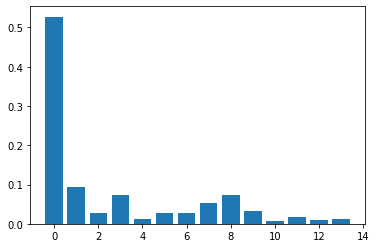

Wall time: 317 ms


In [26]:
%%time
# setting Random forest as sample to view data 
classifier = ExtraTreesRegressor()
clf = classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

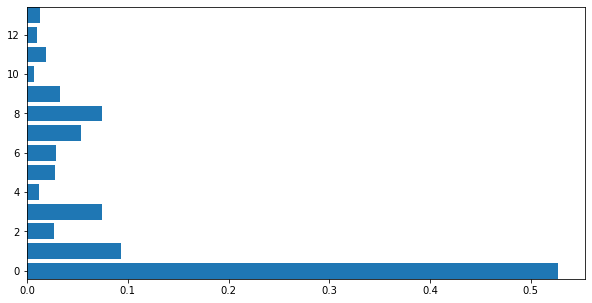

Wall time: 134 ms


In [27]:
%%time
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()
fig.set_size_inches(10,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

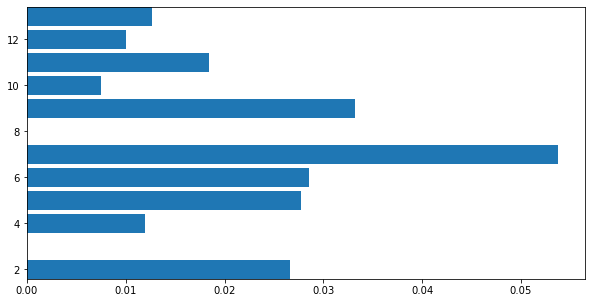

Wall time: 120 ms


In [28]:
%%time
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
features = features[:10]
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()
fig.set_size_inches(10,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [29]:
y_predicted = clf.predict(X_test)
scores1 = clf.score(X_test, y_test)

print(y_predicted)
print(scores1)

[104.4269875  273.97118522 222.35519519 139.05036264 216.41788421
 218.61725105 266.39785674 135.5962848  245.1542612  249.76692927
 102.79586584 114.97363103  46.78494328 169.61801683  16.214
 173.53540293   5.86583333  12.04616667  42.53366667 211.48202771
 248.68965686]
0.9253785791906352


In [30]:
y_predicted = clf.predict(X)
print(y_predicted)

[273.97118522 297.17647059 241.5        290.3125     245.1542612
 210.66666667 280.375      224.14285714 315.23529412 248.68965686
 266.39785674 101.33333333 249.76692927 265.875      205.30769231
 156.41666667 214.88235294 234.58823529 216.41788421 169.14285714
 220.88235294 211.17647059 222.35519519 206.15384615 233.14285714
  81.83333333 180.23076923 255.33333333 218.61725105   0.4
 104.4269875  139.05036264 154.85714286 114.97363103 211.33333333
 169.61801683  68.83333333 286.82352941 214.9375     235.125
 211.48202771 194.16666667  86.         161.83333333 160.75
 173.53540293  92.875      110.75       132.33333333 102.79586584
 105.8        170.5         85.         135.5962848  251.
  25.16666667  42.53366667 190.          45.6         70.33333333
 148.          60.5        194.           7.16666667  20.5
  16.5        135.          12.04616667  18.          46.78494328
  16.214       13.           0.           0.           5.
   5.86583333   0.           0.          25.        

In [31]:
adp_scope['Prediction'] = y_predicted
adp_scope.rename(columns={"2021 Tm": "Team"})

,Player,2019 FantasyPoints,2020 FantasyPoints,2021 FantasyPoints,Production21,Average Total Production,Team,Pos,AVG,Prediction
0,Josh Allen,282.56,395.0,403.0,261.352941,247.325980,BUF,QB,22.8,273.971185
1,Justin Herbert,0.00,333.0,381.0,297.176471,196.103268,LAC,QB,37.8,297.176471
2,Lamar Jackson,415.68,333.0,240.0,241.500000,212.633333,BAL,QB,49.3,241.500000
3,Joe Burrow,0.00,174.0,314.0,290.312500,186.804167,CIN,QB,56.5,290.312500
4,Kyler Murray,279.28,379.0,300.0,272.214286,251.967262,ARI,QB,59.3,245.154261
...,...,...,...,...,...,...,...,...,...,...
78,Jacob Eason,0.00,0.0,-1.0,25.000000,8.333333,IND,QB,0.0,25.000000
79,Feleipe Franks,0.00,0.0,-1.0,0.000000,0.000000,ATL,QB,0.0,0.000000
80,Logan Woodside,0.00,1.0,-1.0,0.000000,0.388889,TEN,QB,0.0,0.000000
81,John Wolford,0.00,13.0,-2.0,1.666667,77.555556,LAR,QB,0.0,1.666667


In [32]:
adp_scope.sort_values('Prediction', ascending=False).head(50)

,Player,2019 FantasyPoints,2020 FantasyPoints,2021 FantasyPoints,Production21,Average Total Production,2021 Tm,Pos,AVG,Prediction
8,Tom Brady,261.68,338.0,375.0,315.235294,287.453431,TAM,QB,82.3,315.235294
1,Justin Herbert,0.00,333.0,381.0,297.176471,196.103268,LAC,QB,37.8,297.176471
3,Joe Burrow,0.00,174.0,314.0,290.312500,186.804167,CIN,QB,56.5,290.312500
37,Patrick Mahomes,285.04,374.0,362.0,286.823529,298.380859,KAN,QB,0.0,286.823529
6,Dak Prescott,335.78,135.0,321.0,280.375000,320.541667,DAL,QB,76.0,280.375000
0,Josh Allen,282.56,395.0,403.0,261.352941,247.325980,BUF,QB,22.8,273.971185
10,Aaron Rodgers,272.38,382.0,332.0,259.500000,260.979167,GNB,QB,92.8,266.397857
13,Kirk Cousins,242.42,306.0,300.0,265.875000,258.852778,MIN,QB,115.5,265.875000
27,Jimmy Garoppolo,243.32,64.0,228.0,255.333333,229.826389,SFO,QB,235.0,255.333333
54,Nick Foles,35.74,104.0,17.0,251.000000,214.212963,CHI,QB,0.0,251.000000


In [33]:
# save
joblib.dump(classifier, "Resources/draft_position_QB.joblib")

# Temporary write file while we are working on data ***
adp_scope.dropna(subset=['AVG'])

adp_scope.to_csv('Resources/Draft_position_QB.csv', index=False)

### <span style='color:green '>The section below is to evaluate new potential Models </scan>

In [34]:
# Create X (features) and y (target) sets
X = pf

#convert y values to categorical values(for model selection matrix)
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
y = y_transformed

# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)
print(len(y))
print(len(X))

83
83


In [35]:
%%time
# call function test_model to test all models being considered
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
test_model(data)

Wall time: 3.88 s


In [36]:
# Print by Training Score
df_scores = pd.DataFrame(scores, index=index)
df_scores.sort_values('Train Score', ascending=False).head(10)

,Train Score,Test Score,Test Train Difference,Scaler
RandomForestClassifier,1.0,0.142857,0.857143,MinMaxScaler()
ExtraTreesRegressor,1.0,0.922863,0.077137,MaxAbsScaler()
ExtraTreesClassifier,1.0,0.142857,0.857143,MinMaxScaler()
ExtraTreesClassifier,1.0,0.142857,0.857143,StandardScaler()
ExtraTreesRegressor,1.0,0.920560,0.079440,StandardScaler()
RandomForestClassifier,1.0,0.142857,0.857143,StandardScaler()
RandomForestClassifier,1.0,0.142857,0.857143,MaxAbsScaler()
ExtraTreesClassifier,1.0,0.142857,0.857143,MaxAbsScaler()
RandomForestClassifier,1.0,0.142857,0.857143,RobustScaler()
ExtraTreesClassifier,1.0,0.142857,0.857143,none


In [37]:
# Print by Testing Score
df_scores.sort_values('Test Score', ascending=False).head(10)

,Train Score,Test Score,Test Train Difference,Scaler
LinearRegression,0.991311,0.981055,0.010255,RobustScaler()
LinearRegression,0.991311,0.981055,0.010255,none
LinearRegression,0.991311,0.981055,0.010255,MaxAbsScaler()
LinearRegression,0.991311,0.981055,0.010255,MinMaxScaler()
LinearRegression,0.991311,0.981055,0.010255,StandardScaler()
ExtraTreesRegressor,1.000000,0.923295,0.076705,RobustScaler()
ExtraTreesRegressor,1.000000,0.922863,0.077137,MaxAbsScaler()
ExtraTreesRegressor,1.000000,0.922280,0.077720,MinMaxScaler()
ExtraTreesRegressor,1.000000,0.920560,0.079440,StandardScaler()
ExtraTreesRegressor,1.000000,0.920104,0.079896,none


In [38]:
# Print by Testing Score
df_scores['Test Train Magnitude'] = abs(df_scores['Test Train Difference'])
df_scores.sort_values('Test Train Magnitude').head(10)

,Train Score,Test Score,Test Train Difference,Scaler,Test Train Magnitude
LogisticRegression,0.145161,0.142857,0.002304,MinMaxScaler(),0.002304
LinearRegression,0.991311,0.981055,0.010255,RobustScaler(),0.010255
LinearRegression,0.991311,0.981055,0.010255,none,0.010255
LinearRegression,0.991311,0.981055,0.010255,MinMaxScaler(),0.010255
LinearRegression,0.991311,0.981055,0.010255,MaxAbsScaler(),0.010255
LinearRegression,0.991311,0.981055,0.010255,StandardScaler(),0.010255
KNeighborsRegressor,0.878111,0.864748,0.013363,none,0.013363
KNeighborsRegressor,0.837511,0.814594,0.022916,MinMaxScaler(),0.022916
KNeighborsRegressor,0.830777,0.791750,0.039026,MaxAbsScaler(),0.039026
ExtraTreesRegressor,1.000000,0.923295,0.076705,RobustScaler(),0.076705
